# 2D EPA implementation


## <font color='blue'> Load nescesssary modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib widget

import sys, os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import cm
from itertools import permutations, combinations

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, mark_inset)
from shapely.validation import make_valid
from shapely.ops import unary_union

from psc.g_space import g, hsurf_g, F, hsurf_F, hsurf_F2
from psc.x2Dlinearize import double_segment_EPA, double_segment_nEPA, single_segment_EPA, single_segment_nEPA 
from psc.x2Dpolygon import multistrip, getploygons_EPA, getploygons_nEPA, polyintersect, get_error
from psc.x2Drepetition import linrep_DS, linrep_SS, writedata, getsigncom, mesh
from psc.x2Dplot import plot_segment, plotisosurf_EPA, plotisosurf_nEPA
from psc.x2Dwritesolution import pseudosolution, realsolution, isInside, analyzesolution

## <font color='blue'> 2D - EPA: Double-segments  (DS)

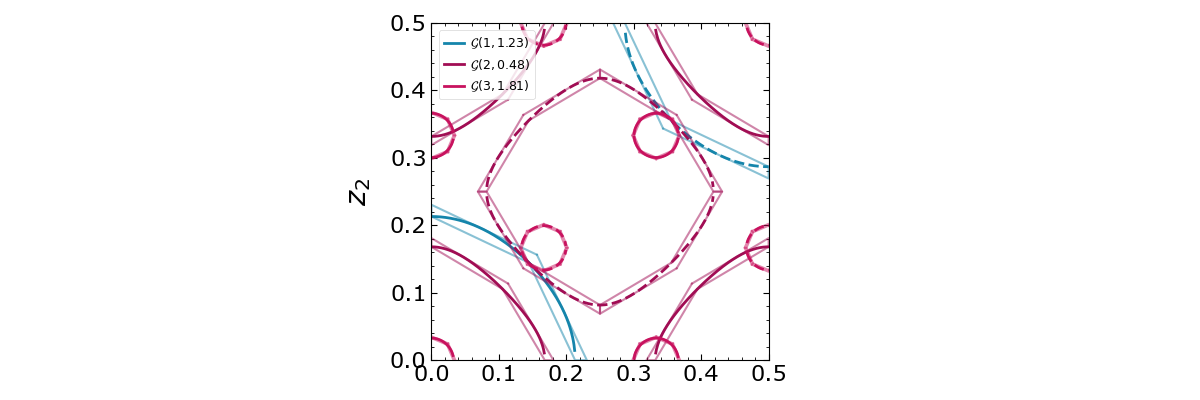

In [7]:

### define random strucutre
xcoor  = [0.349, 0.362]

### assume we solve for second atomic corrdinate 
j     = 1

### defining number of reflection orders to consider
h     = 3
hss   = np.arange(1,h+1)

### generating possible atomic corrdinates in 2D PS. hence grid has dimension of 2x500. 
isos = np.linspace(0., (0.5)/1, 500)  # !!! to change the precision in isosurface change 500 to higher number
grid = [isos]*len(xcoor)

### define plot container
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12,4), subplot_kw = dict(aspect = 1.0))
fig.tight_layout()
ax.set_xlim(isos.min(), isos.max()) ; ax.set_ylim(isos.min(), isos.max())
ax.set_xlabel(r'$z_1$' ,fontsize=21,labelpad=12) ; ax.set_ylabel(r'$z_2$' ,fontsize=21,labelpad=12)
plt.rc('xtick', labelsize=16) ; plt.rc('ytick', labelsize=16)

### open a dat file to store data
fn=open("xpnts_%g.dat"%(h), "wt+")  

### staring amplitude calculation for each RO h and plot them
for ic, l in enumerate(hss):
    xcoor  = np.sort(xcoor)[::-1]
    
    # EPA model
    f     = [1, 1]
    
    # calculate amplitude for given strucutre and RO
    gi    = np.abs(g(l, xcoor, f))
    
    # calculate the isosurface over entrie PS using above gi for s=+1 and s=-1
    giso1 = hsurf_g(l, grid, f, gi, j, s=1)
    giso2 = hsurf_g(l, grid, f, gi, j, s=-1)

    # plot calculated isosurfcae. define cc='k' if same is wanted. or isosurface colour will change automatically
    r = np.random.uniform(0.0, 0.8, 3) ; cc = (r[0],r[1],r[2],1)
    plotisosurf_EPA(l, h, gi, ax, isos, giso1, giso2, cc, lw=2, imax=0.5)
    
    #---> inearization process with error of err 
    errr = 0
    meshlist = mesh(l, xcoor, isos.max())

    #---> double segment method - EPA
    pnts = double_segment_EPA(gi, l, xcoor, f, error=0)
    plist=linrep_DS(l, f, pnts, meshlist, imin=0, imax=0.5)

    #---> single segment method - EPA
    #pnts = single_segment_EPA(gi, l, xexp, f, error=0)
    #plist=linrep_SS(l, f, pnts, meshlist, imin=0, imax=0.5)

    #---> plot segments
    plot_segment(ax, plist, cc)

    #---> storing segment data
    writedata(fn, plist)

fn.close()

plt.legend(loc=2, prop={'size': 9})#, bbox_to_anchor=(1.0, 1.020))
plt.show()


# ---> Post processing to get the given atomic coordinates


# ---> Reading corner points of polygons of given ROs
pointlst = np.loadtxt(os.path.join(os.getcwd(),'xpnts_%g.dat'%(h)),delimiter='\t')

# ---> Getting polygons of given ROs
poly = getploygons_EPA(h, pointlst, imax=0.5)

# ---> Finding solution via intersection of polygons of given ROs
with open ('info.dat', "at+") as finfo:
    solution = polyintersect(h, poly, xcoor, finfo, count=0 )

# ---> Writting found solutions from given ROs
analyzesolution(solution, xcoor, plotting=True)

===> Possible solution (centorid of polygon) ::  POINT (0.1536399215213945 0.1377538963802783)
===> Possible solution (centorid of polygon) ::  [0.15364 0.13775]  or  :  [0.34636 0.36225]
===> Assumed coordinate:  [0.362 0.349]  or ::  [0.138 0.151]
===> Possible uncertanity in solution        ::  -0.010686850481930063 -0.005873478390791692
===> Finals area                             ::  3.5697497270902645e-05 



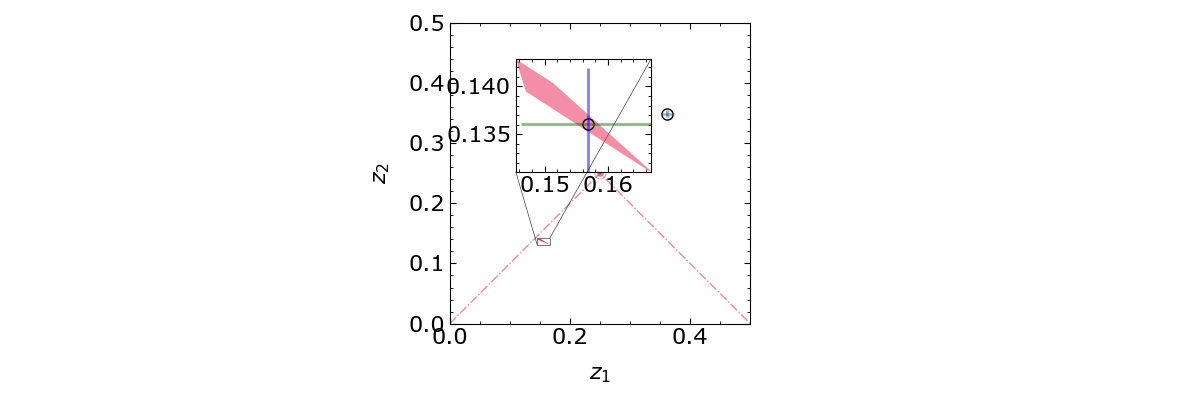

## <font color='blue'> 2D - EPA: Single-segments  (SS)

In [ ]:

### define random strucutre
xcoor  = [0.349, 0.362]

### assume we solve for second atomic corrdinate 
j     = 1

### defining number of reflection orders to consider
h     = 3
hss   = np.arange(1,h+1)

### generating possible atomic corrdinates in 2D PS. hence grid has dimension of 2x500. 
isos = np.linspace(0., (0.5)/1, 500)  # !!! to change the precision in isosurface change 500 to higher number
grid = [isos]*len(xcoor)

### define plot container
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12,4), subplot_kw = dict(aspect = 1.0))
fig.tight_layout()
ax.set_xlim(isos.min(), isos.max()) ; ax.set_ylim(isos.min(), isos.max())
ax.set_xlabel(r'$z_1$' ,fontsize=21,labelpad=12) ; ax.set_ylabel(r'$z_2$' ,fontsize=21,labelpad=12)
plt.rc('xtick', labelsize=16) ; plt.rc('ytick', labelsize=16)

### open a dat file to store data
fn=open("xpnts_%g.dat"%(h), "wt+")  

### staring amplitude calculation for each RO h and plot them
for ic, l in enumerate(hss):
    xcoor  = np.sort(xcoor)[::-1]
    
    # EPA model
    f     = [1, 1]
    
    # calculate amplitude for given strucutre and RO
    gi    = np.abs(g(l, xcoor, f))
    
    # calculate the isosurface over entrie PS using above gi for s=+1 and s=-1
    giso1 = hsurf_g(l, grid, f, gi, j, s=1)
    giso2 = hsurf_g(l, grid, f, gi, j, s=-1)

    # plot calculated isosurfcae. define cc='k' if same is wanted. or isosurface colour will change automatically
    r = np.random.uniform(0.0, 0.8, 3) ; cc = (r[0],r[1],r[2],1)
    plotisosurf_EPA(l, h, gi, ax, isos, giso1, giso2, cc, lw=2, imax=0.5)
    
    #---> inearization process with error of err 
    errr = 0
    meshlist = mesh(l, xcoor, isos.max())

    #---> double segment method - EPA
    #pnts = double_segment_EPA(gi, l, xcoor, f, error=0)
    #plist=linrep_DS(l, f, pnts, meshlist, imin=0, imax=0.5)

    #---> single segment method - EPA
    pnts = single_segment_EPA(gi, l, xexp, f, error=0)
    plist=linrep_SS(l, f, pnts, meshlist, imin=0, imax=0.5)

    #---> plot segments
    plot_segment(ax, plist, cc)

    #---> storing segment data
    writedata(fn, plist)

fn.close()

plt.legend(loc=2, prop={'size': 9})#, bbox_to_anchor=(1.0, 1.020))
plt.show()


# ---> Post processing to get the given atomic coordinates


# ---> Reading corner points of polygons of given ROs
pointlst = np.loadtxt(os.path.join(os.getcwd(),'xpnts_%g.dat'%(h)),delimiter='\t')

# ---> Getting polygons of given ROs
poly = getploygons_EPA(h, pointlst, imax=0.5)

# ---> Finding solution via intersection of polygons of given ROs
with open ('info.dat', "at+") as finfo:
    solution = polyintersect(h, poly, xcoor, finfo, count=0 )

# ---> Writting found solutions from given ROs
analyzesolution(solution, xcoor, plotting=True)